In [1]:
import geopandas as gpd
from pyproj import transform,Proj
from shapely.geometry import MultiPoint, Point

import pandas as pd
import numpy as np

import os
import gc
import warnings

from tqdm import trange,tqdm
from itertools import combinations, permutations

warnings.filterwarnings('ignore')

import glob
from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

%matplotlib inline

os.chdir("../")
root_path = os.getcwd()

data_folder_path = os.path.join(root_path, 'data')
original_file_path = os.path.join(data_folder_path, 'original_data')
original_raw_file_path = os.path.join(original_file_path,'raw_data')
original_processed_file_path = os.path.join(original_file_path,'processed_data')

raw_file_folders = os.listdir(original_raw_file_path)

external_file_path = os.path.join(data_folder_path,'external_data')
external_raw_file_path = os.path.join(external_file_path,'raw_data')
external_processed_file_path = os.path.join(external_file_path,'processed_data')

# image_path = 'C:/Users/rears/OneDrive/바탕 화면/dacon_covid19/'

In [2]:
# raw_file_folders = os.listdir(raw_file_path)
geo_df=gpd.read_file(os.path.join(original_raw_file_path,raw_file_folders[0],'4개지역_행정동.SHP'))

In [4]:
bus_info = os.path.join(external_raw_file_path, 'bus_info')

bus_station_info = [
    pd.read_excel(os.path.join(bus_info, file))
    for file in os.listdir(bus_info) if file.endswith('xlsx')
][0]

bus_route = [
    pd.read_csv(os.path.join(bus_info, file), encoding='cp949')
    for file in os.listdir(bus_info) if file.endswith('csv')
]

bus_route[4] = bus_route[4].drop('bus_route_id', axis=1)
bus_route[5] = bus_route[5].drop('bus_route_id', axis=1)
bus_route[6] = bus_route[6].drop('bus_route_id', axis=1)

bus_route[4].columns = bus_route[0].columns
bus_route[5].columns = bus_route[0].columns
bus_route[6].columns = bus_route[0].columns

bus_route = pd.concat(bus_route)

In [5]:
bus_station_info['point'] = None

In [6]:
bus_station_info.head(10)

,표준ID,ARS-ID,정류장명,X좌표,Y좌표,비고,point
0,100000001,1001,종로2가사거리,126.987750,37.569765,NaN,None
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,NaN,None
2,100000003,1003,명륜3가.성대입구,126.998340,37.582671,NaN,None
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,NaN,None
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,NaN,None
5,101000305,1006,서대문역사거리,126.966893,37.566137,NaN,None
6,100000380,1007,서울역사박물관.경희궁앞,126.970380,37.569135,NaN,None
7,100000379,1008,서울역사박물관.경희궁앞,126.970609,37.569412,NaN,None
8,100000384,1009,광화문,126.975251,37.570135,NaN,None
9,100000385,1010,광화문,126.978085,37.570217,NaN,None


In [7]:
subway_path=os.path.join(external_raw_file_path,'subway')

In [8]:
subway_station = gpd.read_file(os.path.join(subway_path,'substation_pt_sma_170923.shp'))

In [9]:
total_subway_route = subway_station.호선.nunique()

In [10]:
total_subway_route

21

In [12]:
proj_UTMK = Proj(init='epsg:5178')
proj_WGS84 = Proj(init='epsg:4326')

In [13]:
for i in trange(bus_station_info.shape[0]):
    x=bus_station_info.iloc[i,:].X좌표
    y=bus_station_info.iloc[i,:].Y좌표
    
    bus_station_info.iloc[i,-1]=Point(transform(proj_WGS84,proj_UTMK,x,y))

100%|████████████████████████████████████████████████████████████████████████████| 11280/11280 [09:22<00:00, 20.06it/s]


In [12]:
# bus_station_info.head(10)

In [13]:
# subway_station.head(10)

In [14]:
for i in trange(subway_station.shape[0]):
    x = subway_station.iloc[i,:].X
    y = subway_station.iloc[i,:].Y
    
    subway_station.iloc[i,-1]=Point(transform(proj_WGS84,proj_UTMK,x,y))

100%|████████████████████████████████████████████████████████████████████████████████| 695/695 [00:34<00:00, 20.44it/s]


In [15]:
# subway_station.head(10)

In [16]:
# x=geo_df.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))[0][0].x
# y=geo_df.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))[0][0].y

In [15]:
bus_station_indices=[]

for i in trange(bus_station_info.shape[0]):
    if sum(geo_df.geometry.contains(bus_station_info.point[i]))==1:
        bus_station_indices.append(i)

100%|██████████████████████████████████████████████████████████████████████████| 11280/11280 [00:03<00:00, 3543.92it/s]


In [16]:
bus_station_HDONG_NM = {}

for i in tqdm(bus_station_indices):
    bus_station_HDONG_NM[i] = geo_df.iloc[pd.Series(geo_df.geometry.contains(bus_station_info.point[i])+0).idxmax(),2]

100%|██████████████████████████████████████████████████████████████████████████████| 819/819 [00:00<00:00, 1616.59it/s]


In [17]:
subway_station_indices=[]

for i in trange(subway_station.shape[0]):
    if sum(geo_df.geometry.contains(subway_station.geometry[i]))==1:
        subway_station_indices.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 695/695 [00:00<00:00, 3478.15it/s]


In [18]:
subway_station=gpd.GeoDataFrame(subway_station.iloc[subway_station_indices], geometry=gpd.points_from_xy(subway_station.iloc[subway_station_indices].geometry.x, subway_station.iloc[subway_station_indices].geometry.y)).reset_index(drop=True)

In [19]:
subway_station_HDONG_NM = {}

for i in trange(subway_station.shape[0]):
    subway_station_HDONG_NM[i] = geo_df.iloc[pd.Series(geo_df.geometry.contains(subway_station.geometry[i])+0).idxmax(),2]

100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 1490.58it/s]


In [20]:
from collections import Counter

#### 행정동별 버스정류장 개수 

In [23]:
# bus_route.sample(10)

In [21]:
bus_station_info['HDONG_NM']=bus_station_info.index.map(bus_station_HDONG_NM)
bus_station_info=bus_station_info.drop('비고', axis=1).dropna()

In [25]:
# bus_station_info.head()

In [22]:
bus_station_num_by_dong = dict(Counter(bus_station_HDONG_NM.values()))

In [27]:
# bus_station_num_by_dong

In [23]:
bus_station_gdf=gpd.GeoDataFrame(bus_station_info, geometry=gpd.points_from_xy(bus_station_info.point.apply(lambda x: x.x), bus_station_info.point.apply(lambda x: x.y)))

#### 행정동별 버스 노선 개수

In [24]:
station_in_route = bus_route.groupby('노선명')['버스정류장ARS번호'].apply(lambda x : list(x.unique())).reset_index()

In [30]:
# station_in_route.head(10)

In [31]:
# bus_station_info.head()

In [25]:
def convert_station_no(station_list):
    converted_station_no = []
    for station in station_list:
        if station.startswith('0'):
            converted_station_no.append(station[1:])
        else:
            converted_station_no.append(station)
    return converted_station_no

HDONG_NUM = []
for route in station_in_route.reset_index().버스정류장ARS번호.apply(convert_station_no):
    HDONG_NUM.extend(bus_station_info.loc[bus_station_info['ARS-ID'].isin(route)].HDONG_NM.unique())

route_num_by_HDONG=dict(Counter(HDONG_NUM))
route_num_by_HDONG

{'공릉1동': 16,
 '공릉2동': 11,
 '광희동': 16,
 '다산동': 2,
 '동화동': 6,
 '명동': 48,
 '상계10동': 7,
 '상계1동': 6,
 '상계2동': 8,
 '상계3.4동': 3,
 '상계5동': 4,
 '상계6.7동': 13,
 '상계8동': 5,
 '상계9동': 6,
 '소공동': 36,
 '신당5동': 6,
 '신당동': 23,
 '약수동': 4,
 '월계1동': 13,
 '월계2동': 4,
 '월계3동': 12,
 '을지로동': 20,
 '장충동': 6,
 '중계1동': 5,
 '중계2.3동': 8,
 '중계4동': 9,
 '중계본동': 5,
 '중림동': 12,
 '청구동': 4,
 '필동': 6,
 '하계1동': 12,
 '하계2동': 7,
 '황학동': 12,
 '회현동': 39}

In [28]:
# route_num_by_HDONG=dict(Counter(HDONG_NUM))
# route_num_by_HDONG

In [33]:
# pd.DataFrame.from_dict(route_num_by_HDONG, orient='index', columns=['노선수']).head(10)

##### 행정동<->행정동 노선수

In [26]:
station_in_route

,노선명,버스정류장ARS번호
0,0017번(청암동~이촌동),"[03689, 03298, 03321, 03304, 03306, 03308, 033..."
1,01A번(서울역환승센터~서울역환승센터),"[02003, 02118, 02127, 01128, 01127, 01171, 020..."
2,01B번(서울역환승센터~서울역환승센터),"[01114, 02161, 02219, 02006, 02122, 02159, 021..."
3,02번(남산서울타워~동대입구),"[03320, 03167, 02269, 02220, 02221, 02152, 021..."
4,03번(남산서울타워~남산서울타워),"[03320, 03167, 02215, 02120, 02218, 02282, 021..."
...,...,...
657,종로11(삼청공원~서울역),"[01501, 01509, 01518, 01529, 01540, 01551, 011..."
658,종로12(서울대학교병원~종로3가),"[01887, 01883, 01198, 01528, 01539, 01550, 015..."
659,종로13(평창파출소~부암동주민센터.무계원),"[01500, 01508, 01517, 01153, 01538, 01549, 011..."
660,중랑01(중화동동아약국~신이문역),"[07501, 07504, 07506, 07508, 07251, 06254, 065..."


In [27]:
station_in_route.버스정류장ARS번호.apply(convert_station_no)

0      [3689, 3298, 3321, 3304, 3306, 3308, 3310, 331...
1      [2003, 2118, 2127, 1128, 1127, 1171, 2006, 211...
2      [1114, 2161, 2219, 2006, 2122, 2159, 2142, 215...
3      [3320, 3167, 2269, 2220, 2221, 2152, 2153, 220...
4      [3320, 3167, 2215, 2120, 2218, 2282, 2146, 214...
                             ...                        
657    [1501, 1509, 1518, 1529, 1540, 1551, 1126, 250...
658    [1887, 1883, 1198, 1528, 1539, 1550, 1557, 155...
659    [1500, 1508, 1517, 1153, 1538, 1549, 1152, 156...
660    [7501, 7504, 7506, 7508, 7251, 6254, 6525, 625...
661    [7500, 7502, 7505, 7507, 7510, 7231, 7512, 714...
Name: 버스정류장ARS번호, Length: 662, dtype: object

In [36]:
# station_in_route

In [28]:
tmp_dict = {}
for bus_name,route in zip(station_in_route.노선명,station_in_route.버스정류장ARS번호.apply(convert_station_no)):
    if len(bus_station_info.loc[bus_station_info['ARS-ID'].isin(route)].HDONG_NM.unique()) != 0:
        tmp_dict[bus_name] = bus_station_info.loc[bus_station_info['ARS-ID'].isin(route)].HDONG_NM.unique()

In [29]:
hdongs = list(geo_df.loc[geo_df.SIDO_NM=='서울특별시'].HDONG_NM)

In [69]:
# bus_route_dtd = {dong_to_dong:0 for dong_to_dong in combinations(hdongs,2)}

In [30]:
bus_route_dtd = []
for bus_name, hdong_in_route in tmp_dict.items():
    bus_route_dtd.extend(list(permutations(hdong_in_route,2)))

bus_route_num_dtd = dict(Counter(bus_route_dtd))

In [31]:
# Counting이 제대로 되었는지 확인
for dtd, route_num in bus_route_num_dtd.items():
    start=dtd[0]
    end=dtd[1]
    if bus_route_num_dtd.get((end,start)) != route_num:
        print(dtd)

In [32]:
list_for_df = []
for dtd, route_num in bus_route_num_dtd.items():
    start, end = dtd
    list_for_df.append(np.array([start,end,int(route_num)]))

In [33]:
bus_route_num_df = pd.DataFrame(list_for_df, columns = ['dong1','dong2','route_num']).pivot('dong1','dong2','route_num').fillna(0)

In [34]:
bus_route_num_df = bus_route_num_df.astype(int)

In [37]:
# bus_route_num_df

In [38]:
# bus_route_num_dtd.to_csv(os.path.join(external_processed_file_path,"bus_route_num_dtd.csv"))

#### 행정동별 지하철역 개수

In [39]:
subway_station['HDONG_NM']=subway_station.index.map(subway_station_HDONG_NM)

In [47]:
# 환승역의 경우 역 개수를 어떻게 지정할지?
# subway_station.drop_duplicates(['X','Y'],keep='last')

In [40]:
subway_station_num_by_HDONG=dict(Counter(subway_station_HDONG_NM.values()))

In [41]:
subway_route_num_by_HDONG=dict(subway_station.groupby(['HDONG_NM'])['호선'].nunique())

In [50]:
# pd.DataFrame.from_dict(subway_route_num_by_HDONG, orient='index', columns=['호선수']).head(10)

In [42]:
dict(subway_station.groupby(['X','Y','HDONG_NM']).size().reset_index().groupby('HDONG_NM').size())

{'공릉1동': 1,
 '광희동': 1,
 '다산동': 1,
 '명동': 3,
 '상계10동': 1,
 '상계1동': 1,
 '상계3.4동': 1,
 '상계6.7동': 1,
 '소공동': 1,
 '신당5동': 1,
 '신당동': 2,
 '약수동': 1,
 '월계3동': 2,
 '을지로동': 2,
 '중계2.3동': 1,
 '중계4동': 1,
 '중림동': 1,
 '청구동': 1,
 '필동': 2,
 '하계1동': 1,
 '황학동': 1,
 '회현동': 1}

In [45]:
geo_df_seoul = geo_df.loc[geo_df.SIDO_NM=='서울특별시'].reset_index(drop=True)

In [46]:
tmp = geo_df_seoul[['HDONG_NM','SGNG_NM']]

tmp['sub_num'] = tmp.HDONG_NM.map(dict(subway_station.groupby(['X','Y','HDONG_NM']).size().reset_index().groupby('HDONG_NM').size()))
tmp = tmp.fillna(0)

In [47]:
tmp.groupby('SGNG_NM').sub_num.mean()

SGNG_NM
노원구    0.526316
중구     1.200000
Name: sub_num, dtype: float64

##### 행정동 <-> 행정동 호선수 

In [48]:
subway_dtd = []
for route in subway_station.groupby('호선')['HDONG_NM'].apply(lambda x: list(x.unique())).values:
    subway_dtd.extend(list(permutations(route,2)))

In [49]:
base_dict = {dongs:0 for dongs in list(permutations(hdongs,2))}

In [50]:
base_dict.update(dict(Counter(subway_dtd)))

In [51]:
# Counting이 제대로 되었는지 확인
for dtd, route_num in base_dict.items():
    start=dtd[0]
    end=dtd[1]
    if base_dict.get((end,start)) != route_num:
        print(dtd)

In [52]:
list_for_df_subway = []
for dtd, route_num in base_dict.items():
    start, end = dtd
    list_for_df_subway.append(np.array([start,end,int(route_num)]))

In [53]:
subway_route_num_df = pd.DataFrame(list_for_df_subway, columns = ['dong1','dong2','route_num']).pivot('dong1','dong2','route_num').fillna(0)

In [54]:
subway_route_num_df = subway_route_num_df.astype(int)

In [416]:
# subway_route_num_df

#### 지하철역 및 버스정류소 분포

In [55]:
geo_df['center'] = geo_df.geometry.centroid

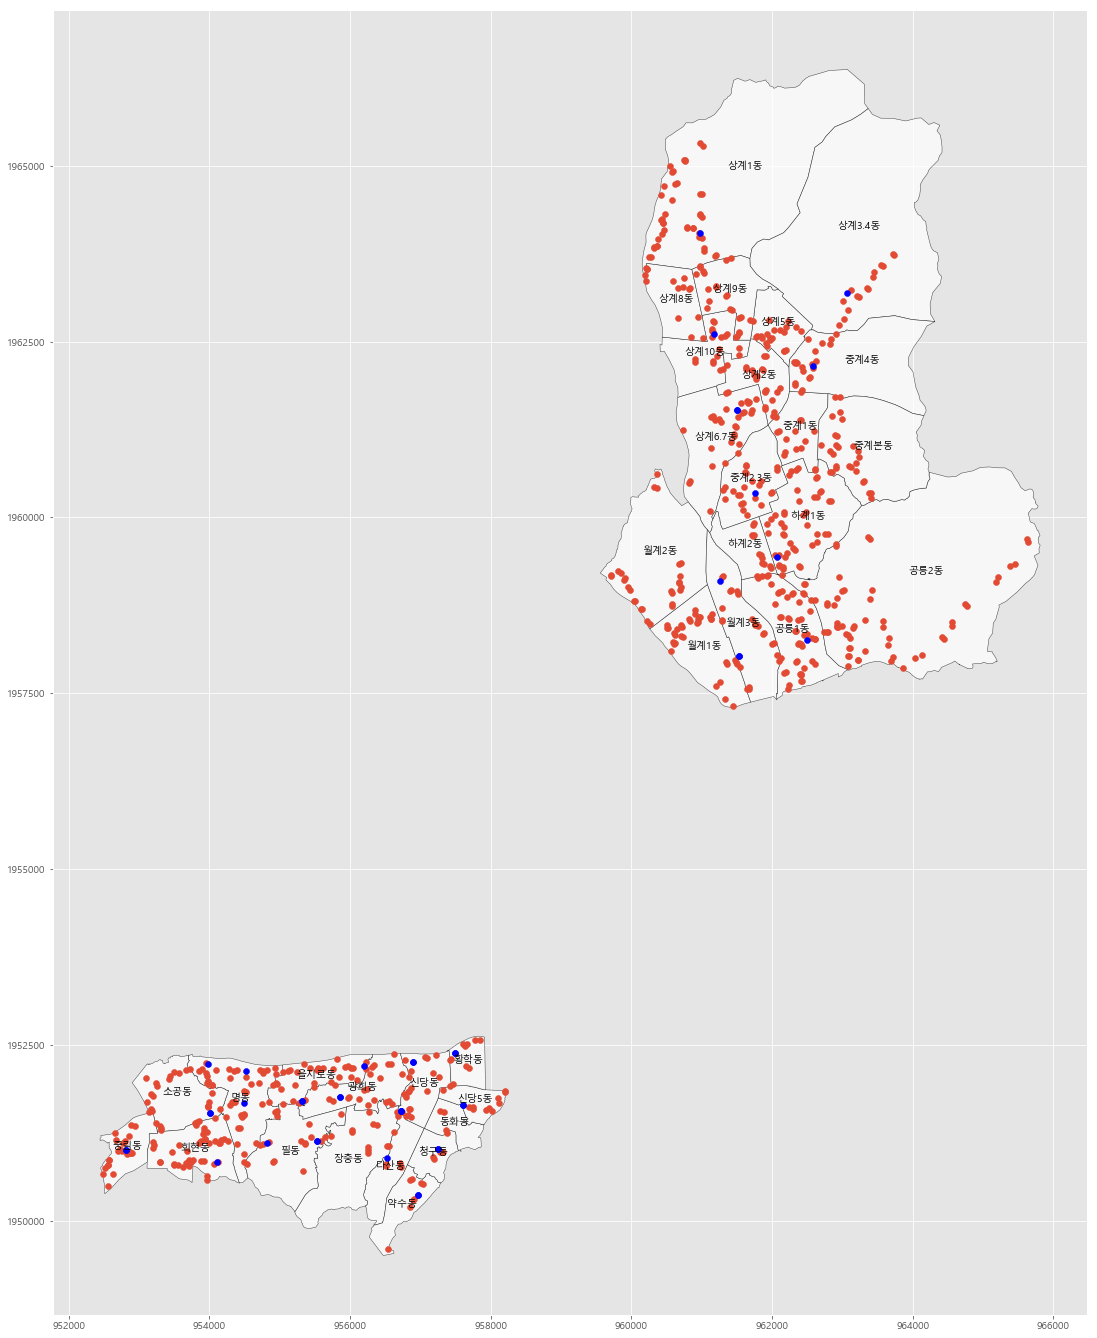

In [56]:
fig, ax = plt.subplots(figsize=(32,24))
geo_df.loc[geo_df.SIDO_NM=='서울특별시'].plot(ax=ax, color='white', alpha=0.7, edgecolor='k')
bus_station_gdf.plot(ax=ax)
subway_station.plot(ax=ax, color='b')

for idx, row in geo_df.loc[geo_df.SIDO_NM=='서울특별시'].iterrows():
    ax.annotate(row['HDONG_NM'], (row['center'].x,row['center'].y), fontsize=10, ha='center')

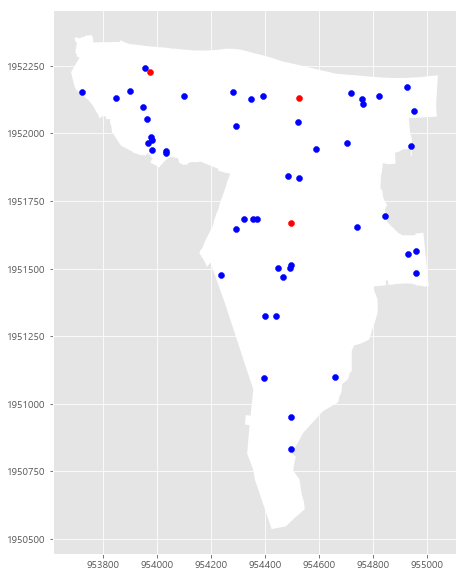

In [57]:
fig, ax = plt.subplots(figsize=(12,10))

geo_df.loc[geo_df.HDONG_NM=='명동'].plot(ax=ax, color='white')
bus_station_gdf.loc[bus_station_gdf.HDONG_NM=='명동'].plot(ax=ax, color='blue')
subway_station.loc[subway_station.HDONG_NM=='명동'].plot(ax=ax, color='r')

#### 교통편의성

In [58]:
HDONG_NM=geo_df.loc[geo_df.SIDO_NM=='서울특별시'][['HDONG_NM']].reset_index(drop=True)

HDONG_NM['subway_station_num']=HDONG_NM.HDONG_NM.map(subway_station_num_by_HDONG).fillna(0)
HDONG_NM['bus_station_num']=HDONG_NM.HDONG_NM.map(bus_station_num_by_dong).fillna(0)
HDONG_NM['bus_route_num'] = HDONG_NM.HDONG_NM.map(route_num_by_HDONG).fillna(0)
HDONG_NM['subway_route_num'] = HDONG_NM.HDONG_NM.map(subway_route_num_by_HDONG).fillna(0)

In [59]:
HDONG_conv_index = HDONG_NM.merge(geo_df[['HDONG_NM','AREA']])

In [63]:
# HDONG_conv_index.head(10)

$CONV\ INDEX = {100000 \cdot (\#subway\_route \cdot 15 + \#bus\_route) \over AREA}  $

In [60]:
HDONG_conv_index['conv_index'] = np.log((HDONG_NM.merge(geo_df[['HDONG_NM','AREA']]).subway_route_num*15+HDONG_NM.merge(geo_df[['HDONG_NM','AREA']]).bus_route_num)/(HDONG_NM.merge(geo_df[['HDONG_NM','AREA']]).AREA)*100000)

In [67]:
# HDONG_conv_index.to_csv("HDONG_conv_index.csv", index=False, encoding='utf-8')

In [61]:
HDONG_NM.merge(geo_df[['HDONG_NM','AREA']]).eval('conv=(subway_route_num*20+bus_route_num)/AREA*100000').sort_values(by='conv', ascending=False).head()

,HDONG_NM,subway_station_num,bus_station_num,bus_route_num,subway_route_num,AREA,conv
25,신당동,5.0,21,23,4.0,544408.19,18.919627
32,황학동,2.0,9,12,2.0,328678.23,15.820944
24,신당5동,2.0,11,6,2.0,321347.03,14.314743
27,을지로동,3.0,32,20,3.0,599091.52,13.353552
30,청구동,2.0,5,4,2.0,336949.37,13.058342


In [62]:
conv_index=HDONG_NM.merge(geo_df[['HDONG_NM','AREA']]).eval('conv=(subway_route_num*20+bus_route_num)/AREA*100000').sort_values(by='conv', ascending=False)

In [63]:
conv_index = conv_index.reset_index(drop=True)

In [69]:
# HDONG_conv_index

In [42]:
# conv_index.to_csv("conv_index.csv", index=False, encoding='utf-8')

In [71]:
# HDONG_NM.merge(geo_df[['HDONG_NM','AREA']]).head()

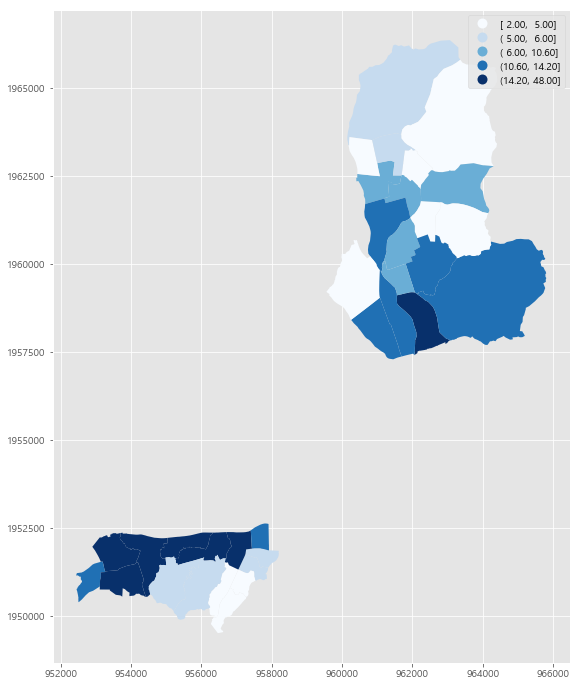

In [73]:
geo_df_seoul.merge(HDONG_NM).plot(figsize=(10,12), column='bus_route_num', cmap='Blues', legend=True, scheme='quantiles')

#### 정류장별 노선갯수 

In [64]:
route_num_by_station=bus_route.groupby(['버스정류장ARS번호'])['노선번호'].apply(lambda x: x.nunique()).reset_index(name='노선수')

In [69]:
# route_num_by_station.loc[route_num_by_station.버스정류장ARS번호!='~']['버스정류장ARS번호'].apply(lambda x : str(x)[1:] if x.startswith('0') else str(x))

In [65]:
start_end_point=bus_route.loc[bus_route.버스정류장ARS번호=='~'].index

In [66]:
bus_route=bus_route.drop(start_end_point)

In [67]:
bus_route.reset_index(drop=True, inplace=True)

In [68]:
bus_route['사용일자']=pd.to_datetime(bus_route['사용일자'], format='%Y%m%d')

In [70]:
station_HDONG=bus_station_info[['ARS-ID','HDONG_NM']].set_index('ARS-ID').to_dict().get('HDONG_NM')

In [71]:
# bus_route['버스정류장ARS번호'].apply(lambda x : int(x[1:]) if x.startswith('0') else int(x)).map(station_HDONG).dropna().to_dict()

In [72]:
bus_route['HDONG_NM'] = None

In [73]:
bus_route['HDONG_NM'] = bus_route.index.map(bus_route['버스정류장ARS번호'].apply(lambda x : int(x[1:]) if x.startswith('0') else int(x)).map(station_HDONG).dropna().to_dict())

In [74]:
bus_route_sub = bus_route.dropna().reset_index(drop=True)

In [85]:
# bus_route_sub.groupby(['HDONG_NM','버스정류장ARS번호'])['노선번호'].unique().reset_index().head()

In [86]:
# 행정동별 가장 많은 노선을 가지고 있는 버스정류장의 노선 수

# bus_route_sub.groupby(['HDONG_NM','버스정류장ARS번호'])['노선번호'].nunique().reset_index().groupby(['HDONG_NM'])['노선번호'].max().reset_index().sort_values(by='노선번호', ascending=False)

#### 버스정류장별 승하차 인원, 지하철 승하차 인원

In [75]:
subway_use=pd.read_csv(os.path.join(external_raw_file_path,'CARD_SUBWAY_MONTH_202007.csv'))

In [88]:
# bus_route.groupby(['사용일자','버스정류장ARS번호'])['하차총승객수'].sum().reset_index()

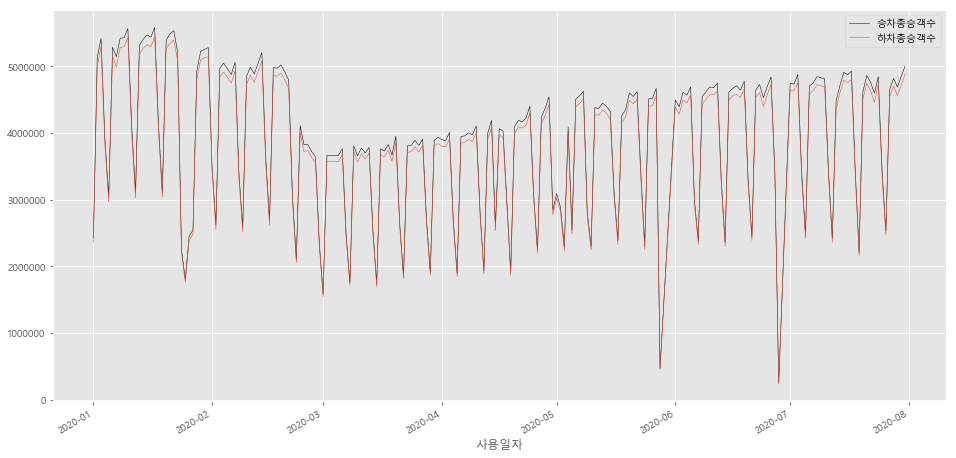

In [76]:
fig, ax = plt.subplots(figsize=(16,8))
bus_route.groupby(['사용일자'])['승차총승객수'].sum().reset_index().set_index('사용일자').plot(ax=ax, linewidth=.5, color='k')
bus_route.groupby(['사용일자'])['하차총승객수'].sum().reset_index().set_index('사용일자').plot(ax=ax, linewidth=.5)

In [77]:
bus_route['year'] = bus_route['사용일자'].dt.year.values
bus_route['month'] = bus_route['사용일자'].dt.month.values
bus_route['weekofyear'] = bus_route['사용일자'].dt.weekofyear.values
bus_route['dayofweek'] = bus_route['사용일자'].dt.dayofweek.values

bus_route['weekday'] = np.where(bus_route.dayofweek<5,'평일','주말')

In [91]:
# bus_route_sub.loc[bus_route_sub.HDONG_NM=='명동'].groupby(['사용일자'])['승차총승객수'].sum().reset_index()

#### 동별 거리 측정

In [79]:
geo_seoul=geo_df.query('SIDO_NM==\'서울특별시\'').reset_index(drop=True)

In [80]:
distances = []
for i in range(geo_seoul.shape[0]):
    distance = []
    for j in range(geo_seoul.shape[0]):
        if i == j:
            distance.append(0)
        else:
            distance.append(geo_seoul.iloc[i,-2].distance(geo_seoul.iloc[j,-2]))
    distances.append(distance) 

In [81]:
distances_center = []
for i in range(geo_seoul.shape[0]):
    distance = []
    for j in range(geo_seoul.shape[0]):
        if i == j:
            distance.append(0)
        else:
            distance.append(geo_seoul.iloc[i,-1].distance(geo_seoul.iloc[j,-1]))
    distances_center.append(distance) 

In [82]:
distance_dong_to_dong = pd.DataFrame(distances, columns=geo_seoul.HDONG_NM.tolist(), index=geo_seoul.HDONG_NM.tolist())
distance_center_dong_to_dong = pd.DataFrame(distances_center, columns=geo_seoul.HDONG_NM.tolist(), index=geo_seoul.HDONG_NM.tolist())

In [83]:
distance_dong_to_dong.to_csv(os.path.join(external_processed_file_path,"distance_dong_to_dong.csv"), encoding='utf-8')
distance_center_dong_to_dong.to_csv(os.path.join(external_processed_file_path,"distance_center_dong_to_dong.csv"), encoding='utf-8')

In [84]:
HDONG_NM

,HDONG_NM,subway_station_num,bus_station_num,bus_route_num,subway_route_num
0,공릉1동,1.0,49,16,1.0
1,공릉2동,0.0,59,11,0.0
2,상계10동,1.0,19,7,1.0
3,상계1동,1.0,45,6,1.0
4,상계2동,0.0,24,8,0.0
5,상계3.4동,1.0,15,3,1.0
6,상계5동,0.0,21,4,0.0
7,상계6.7동,2.0,30,13,2.0
8,상계8동,0.0,13,5,0.0
9,상계9동,0.0,24,6,0.0


___

#### 교통편의성.v2

##### CONV IN

$Conv\_In_{n,n} = \begin{bmatrix}
    c_{1} & & \\
    & \ddots & \\
    & & c_{n}
  \end{bmatrix}\ \ s.t\ \ c_i={\# bus\ station\ in\ h_i \over AREA(h_i)}$

In [85]:
HDONG_conv_index_v2 = HDONG_NM.merge(geo_df[['HDONG_NM','AREA']])

In [86]:
conv_in = dict(HDONG_conv_index_v2.eval("conv_in = bus_station_num/AREA*10000").set_index('HDONG_NM').conv_in)

In [87]:
conv_in_matrix=np.diag(HDONG_conv_index_v2.eval("conv_in = bus_station_num/AREA*10000").set_index('HDONG_NM').conv_in.values)

In [170]:
# HDONG_conv_index_v2.eval("conv_in = (bus_station_num)/AREA*10000").sort_values(by = 'conv_in', ascending=False).head()

##### CONV OUT 

$Conv\_Out_{n,n} = D_{n,n} \odot R_{n,n}$
$(elementwise\ multiplication\ of\ D_{n,n}\ \text{$and$}\ R_{n,n})$

$D_{n,n} = \{d_{i,j}\} \ s.t\ \ d_{i,j}= \begin{cases}
\left (1-\left (Dist(h_i,h_j) \over d \right)^2 \right )^2 & \text{if $0 \le Dist(h_i,h_j) \le d $} \\
0 & \text{if $Dist(h_i,h_j) > d$}\end{cases}$

$R_{n,n} = \{r_{i,j}\}\ s.t\ \ r_{i,j} = \begin{cases}
\sqrt{\left ({bus\ route (h_i,h_j) \over total\ bus\ route} \right)} + \sqrt{\left ({subway\ route (h_i,h_j) \over total\ subway\ route} \right)}& \text{if $ i \ne j$} \\
0 & \text{if $ i=j $}\end{cases}$

$ Double\ Power\ Distance\ Weights $  

In [89]:
total_bus_route=bus_route.노선번호.nunique()

In [289]:
# total_subway_route=gpd.read_file(os.path.join(subway_path,'substation_pt_sma_170923.shp')).호선.nunique()

In [90]:
distance_file=[pd.read_csv(os.path.join(external_processed_file_path,file), index_col=[0]) for file in os.listdir(external_processed_file_path) if file.startswith('distance')]

In [91]:
real_dist = distance_file[0]

In [414]:
# for dong, adj_dongs in adjacent_dong_dict.items():
#     print(real_dist.loc[dong,adj_dongs].max())

In [93]:
# 거리별 가중치 계산
def double_power_distance_weight(df, distance):
    shape = df.shape
    names = df.columns.tolist()
    flatten_values = np.concatenate(df.values)
    weights = np.array([(1-(dist/distance)**2) if dist < distance else 0 for dist in flatten_values ])
    weights_df = pd.DataFrame(weights.reshape(shape), columns = names)
    weights_df.index = names
    return weights_df

In [94]:
dong_order=real_dist.columns.tolist()

In [95]:
conv_bus=np.sqrt(bus_route_num_df/total_bus_route)
conv_bus=conv_bus.loc[dong_order,dong_order]

In [96]:
conv_subway=np.sqrt(subway_route_num_df/total_subway_route)
conv_subway=conv_subway.loc[dong_order,dong_order]

In [97]:
conv_out_df = np.multiply(
    double_power_distance_weight(real_dist,3000),
    conv_bus+conv_subway
)

In [98]:
pd.options.display.max_columns=35

In [115]:
"""
adjacent_dist = distance_file[1]

HDONGS=adjacent_dist.columns.tolist()
adjacent_dong_dict = {}
    
for i,dong in tqdm(enumerate(HDONGS), desc='Finding Adjacent Dongs'):
    adjacent_dong_dict[dong] = list(adjacent_dist.loc[adjacent_dist[dong]==0,HDONGS[i]].drop(dong).index)

mean_bus_route_num_to_adj_dongs = {}
for dong, adj_dongs in adjacent_dong_dict.items():
    mean_bus_route_num_to_adj_dongs[dong]=bus_route_num_df.loc[dong, adj_dongs].mean()

mean_bus_route_dtd = pd.DataFrame.from_dict(mean_bus_route_num_to_adj_dongs, 'index', columns=['mean_bus_route_dtd']).reset_index().rename(columns={'index':'HDONG_NM'})
"""

##### CONV INDEX 

$CONV\_INDEX_{n,n} = Conv\_IN_{n,n} + Conv\_Out_{n,n}$

In [155]:
import copy

In [156]:
"""
conv_df = copy.deepcopy(conv_out_df)

for dong, _ in conv_in.items():
    conv_df.loc[dong,dong] = conv_in.get(dong)
"""

In [99]:
conv_df = conv_in_matrix + conv_out_df

In [101]:
conv_df.to_csv(os.path.join(external_processed_file_path,"conv_index_df.csv"))